# Import Our Data

Save the data to your Google Drive. Then you can mount your drive and access the folder from wherever you saved it.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Here, we are using the image_dataset_from_directory utilty, which reads images from a file path into a tf.Dataset object. This is much more memory efficient than reading images into lists! The dataset is already organized into training, test, and validation splits on my file system. The labels are inferred from the folder names.

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

base_dir = "drive/My Drive/Teaching/Courses/BA 865/BA865-2025/Lecture Materials/Week 3/dogs-vs-cats/"

train_dataset = image_dataset_from_directory(
    base_dir + "/train/",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir + "/validation/",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir + "/test/",
    image_size=(180, 180),
    batch_size=32)

Found 765 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 798 files belonging to 2 classes.


In [6]:
for data_batch, labels_batch in train_dataset:
     print("data batch shape:", data_batch.shape)
     print("labels batch shape:", labels_batch.shape)
     break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# Define Our Model

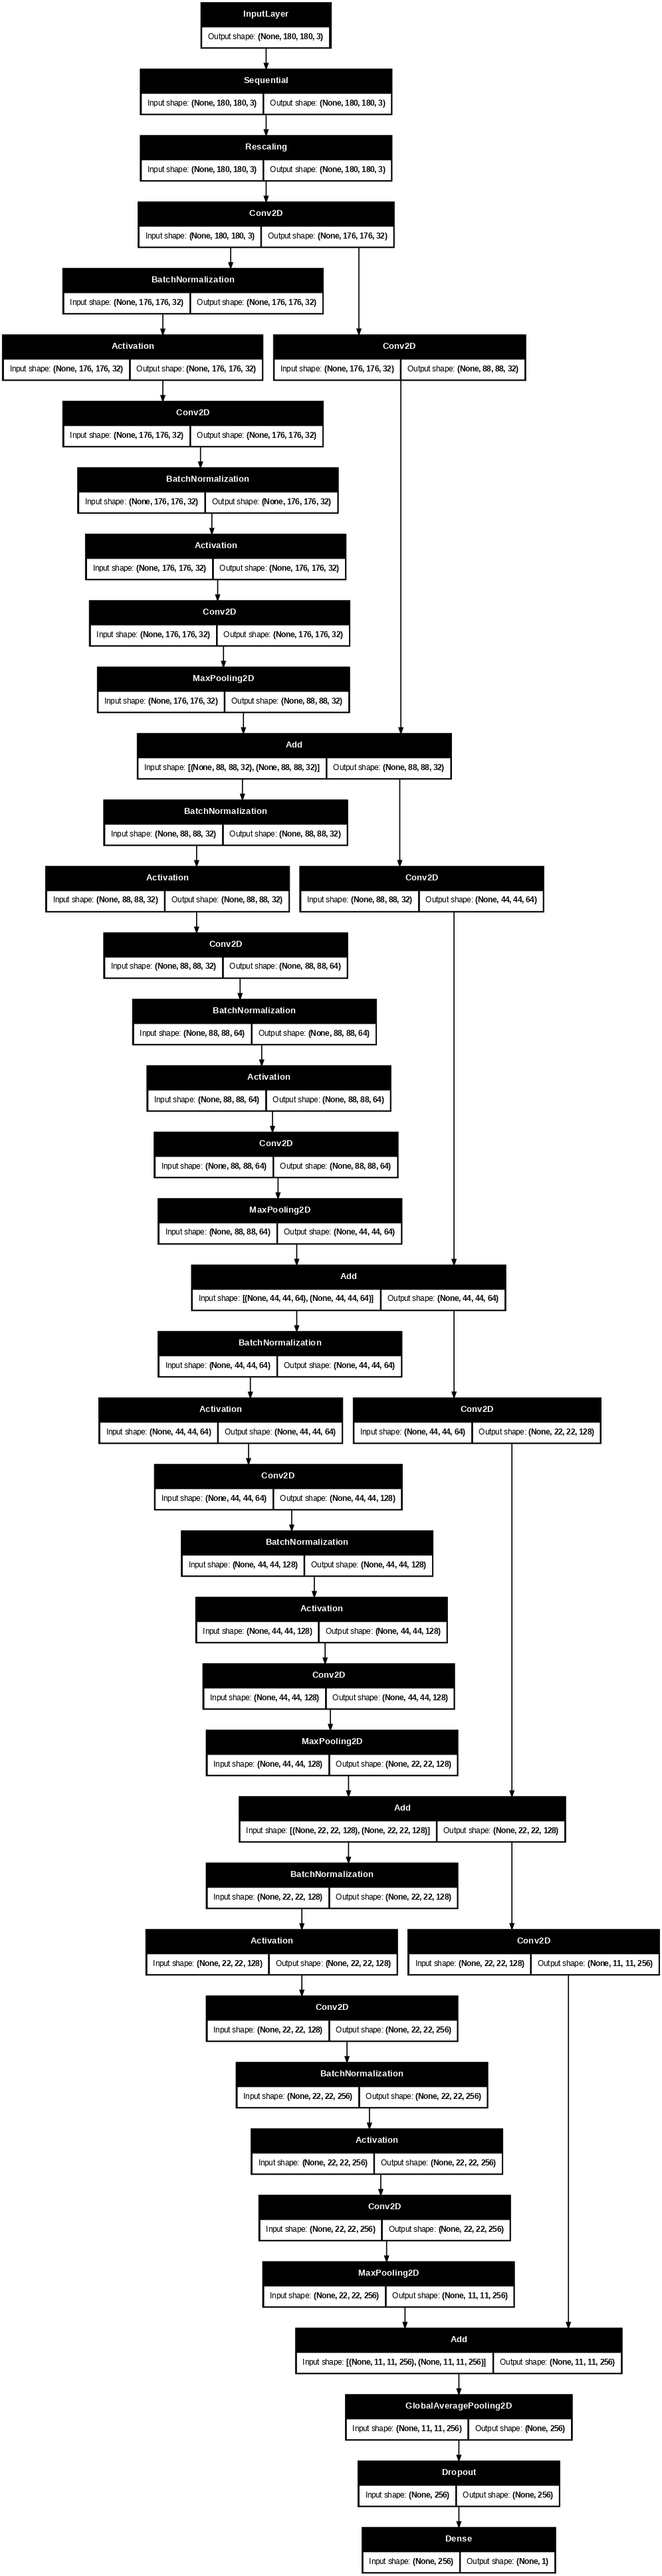

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

keras.utils.plot_model(model,show_shapes=True,dpi=60)

We have a binary outcome variable, hence our use of Sigmoid activation on the output layer. We will use binary cross-entropy loss as our loss function. And, we'll monitor accuracy.

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

This callback we are defining will write the current best model (and parameter values) to disk, based on minimum validation loss.

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Xception.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 180, 180, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 180, 180, 3)    │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 176, 176, 32)   │          2,400 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 176, 176, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 176, 176, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 176, 176, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 176, 176, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 176, 176, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 176, 176, 32)   │          9,216 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 88, 88, 32)     │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 88, 88, 32)     │          1,024 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 88, 88, 32)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 88, 88, 32)     │            128 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 88, 88, 32)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 88, 88, 64)     │         18,432 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 88, 88, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization) 

 Total params: 310,113 (1.18 MB)

 Trainable params: 309,409 (1.18 MB)

 Non-trainable params: 704 (2.75 KB)

Note that batch size isn't defined here, because we defined it when we first created the tf.Dataset object! This Dataset object is an iterator, containing batches of images.

In [11]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.5135 - loss: 5.7804 - val_accuracy: 0.5000 - val_loss: 0.6978
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.5316 - loss: 1.8507 - val_accuracy: 0.5000 - val_loss: 0.7322
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - accuracy: 0.5434 - loss: 1.2459 - val_accuracy: 0.5000 - val_loss: 3.2972
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.5597 - loss: 1.5934 - val_accuracy: 0.5000 - val_loss: 0.9804
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.5488 - loss: 1.7954 - val_accuracy: 0.5000 - val_loss: 0.7312
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.5447 - loss: 1.1682 - val_accuracy: 0.5000 - val_loss: 1.1816
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.5324 - loss: 1.0797 - val_accuracy: 0.4950 - val_loss: 0.7015
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.5681 - loss: 1.5952 - val_a

And we can plot loss over training iterations...

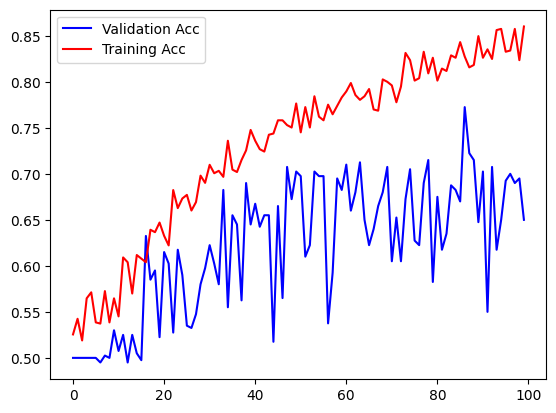

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'],c="b")
plt.plot(history.history['accuracy'],c="r")
plt.legend(['Validation Acc','Training Acc'])
plt.show()

Note that we can now reach ~70% accuracy with 100 epochs of learning...

In [13]:
test_model = keras.models.load_model("Xception.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.7454 - loss: 0.5616
Test accuracy: 0.7180451154708862
